<a href="https://colab.research.google.com/github/GentaKanno/tyushutu_honban/blob/main/%E6%96%87%E5%AD%97%E6%8A%BD%E5%87%BA%E6%9C%AC%E7%95%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

外接矩形: x=40, y=19, w=176, h=219
縦横比（h/w）: 1.244
外接矩形: x=40, y=19, w=176, h=219
縦横比（h/w）: 1.244


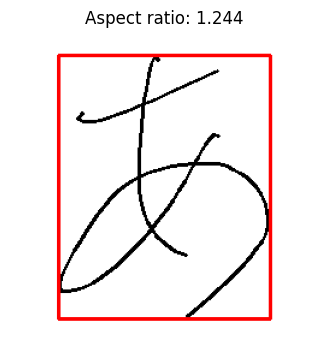

外接矩形: x=88, y=81, w=188, h=224
外接矩形の縦横比: 1.191


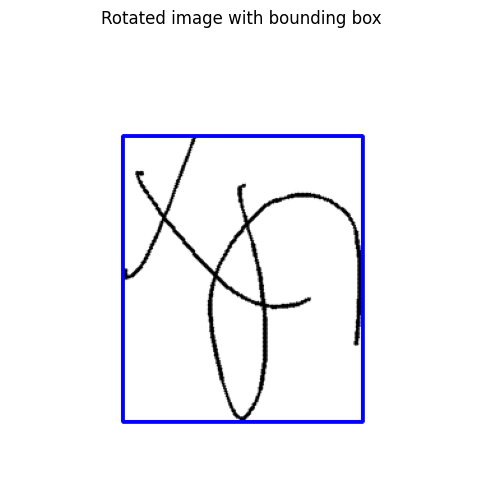

領域1の黒画素率: 0.0392
領域2の黒画素率: 0.0314
領域3の黒画素率: 0.0502
領域4の黒画素率: 0.0360

4領域の黒画素率: [np.float64(0.03924560546875), np.float64(0.03143310546875), np.float64(0.05023193359375), np.float64(0.0360107421875)]
エントロピー: 1.9781


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40658 (\N{CJK UNIFIED IDEOGRAPH-9ED2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

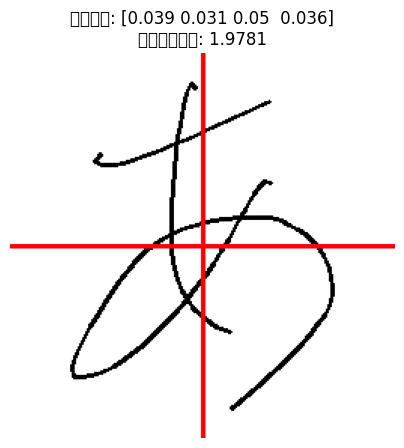

上の黒画素率: 0.0353
下の黒画素率: 0.0431
黒画素率の比（上:下）= 0.8195


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


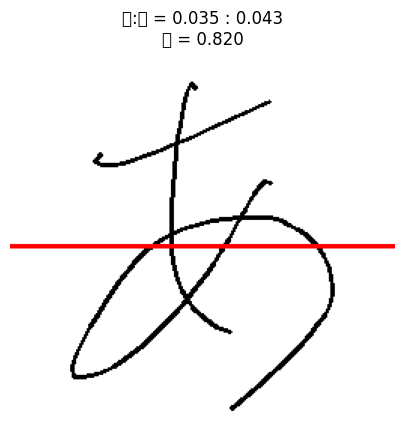

左の黒画素率: 0.0447
右の黒画素率: 0.0337
黒画素率の比（左:右）= 1.3267


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24038 (\N{CJK UNIFIED IDEOGRAPH-5DE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21491 (\N{CJK UNIFIED IDEOGRAPH-53F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


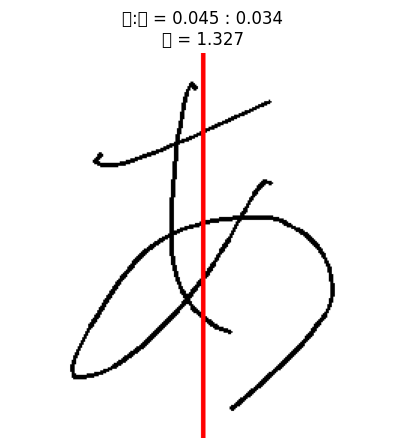

第1象限: 0.0314
第2象限: 0.0392
第3象限: 0.0502
第4象限: 0.0360
対角黒画素率比 (1+3) / (2+4) = 1.0852


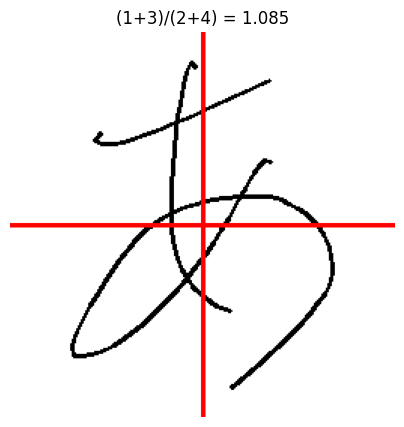

第1象限の距離: 47.84
第2象限の距離: 57.16
第3象限の距離: 62.68
第4象限の距離: 70.58

距離のエントroピー: 1.9859


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


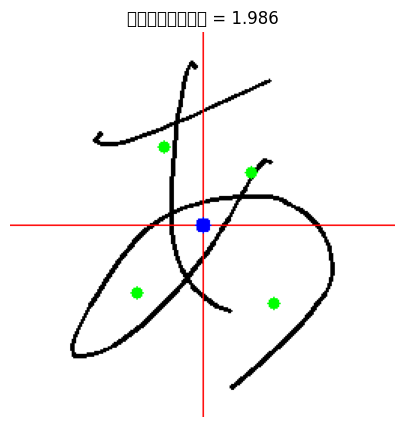

各象限の角度（ラジアン）:
第1象限: 0.812 rad
第2象限: 2.030 rad
第3象限: -2.339 rad
第4象限: -0.841 rad

平均角度: 0.629 rad
円周標準偏差: 2.3257


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

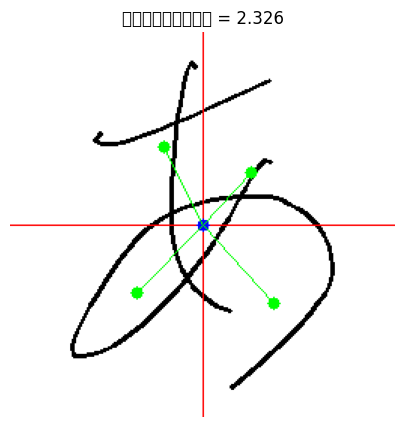

上側重心のx座標: 128.56
下側重心のx座標: 122.28
x方向の差（上 - 下）: 6.28


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


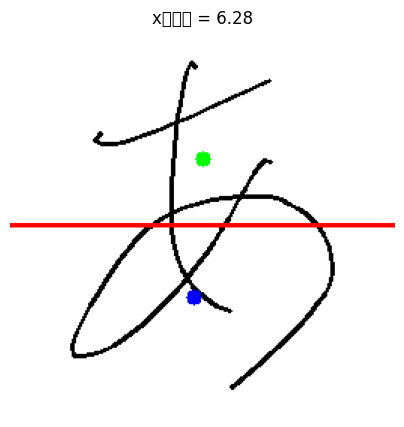

左側重心のy座標: 130.83
右側重心のy座標: 139.91
y方向の差（左 - 右）: -9.07


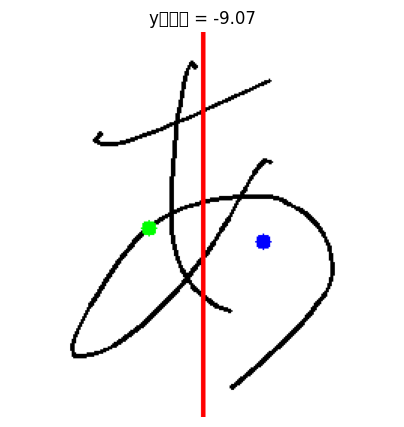

各部分系の黒画素数（背景除く）:
部分系 {k}: {area} pixels
部分系の数: 1
部分系が1つのため、比・エントロピーはなし。


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


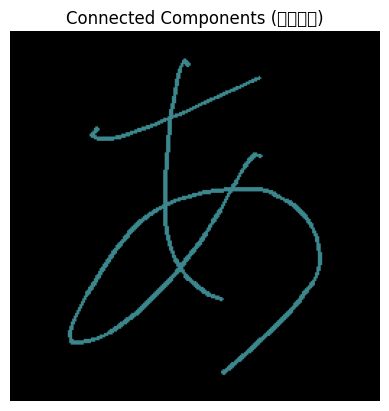

各部分系の外接矩形の面積（背景除く）:
部分系 1: 外接矩形面積 = 38544
部分系の数: 1
部分系が1つのため、比・エントロピーはなし。


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


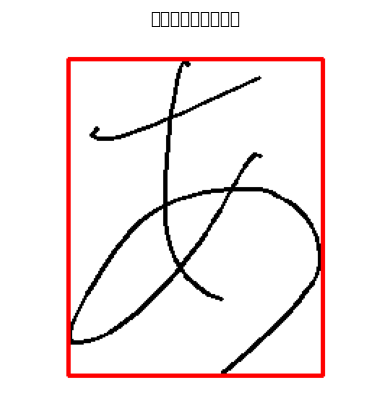

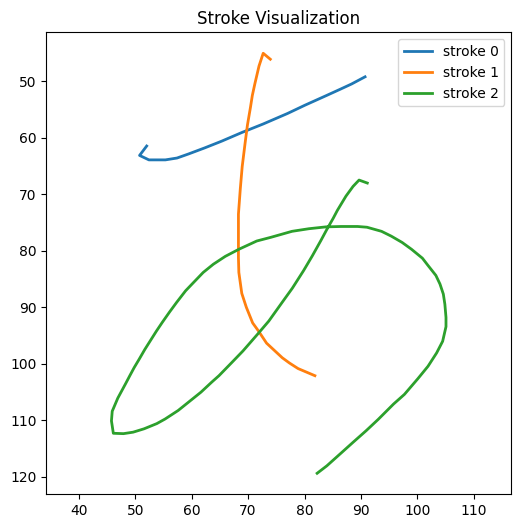

ストローク数: 3
各ストロークの画素数: [350, 562, 1687]
ストロークが3本 → エントロピー = 1.272 bits
ストローク数: 3
各ストロークの外接矩形面積（筆順）: [4954.23, 6520.67, 25943.47]
ストロークが3本 → 外接矩形面積分布のエントロピー = 1.192 bits


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

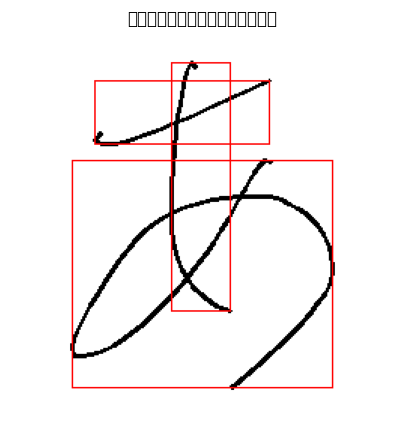

外接矩形: x=19, y=60, w=219, h=136
縦横比（h/w）: 0.621
外接矩形: x=19, y=60, w=219, h=136
縦横比（h/w）: 0.621


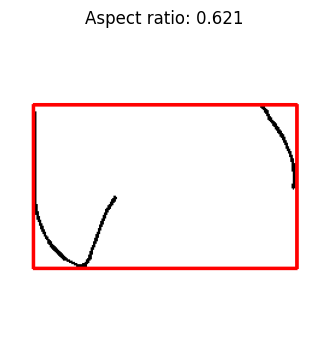

外接矩形: x=60, y=75, w=199, h=209
外接矩形の縦横比: 1.050


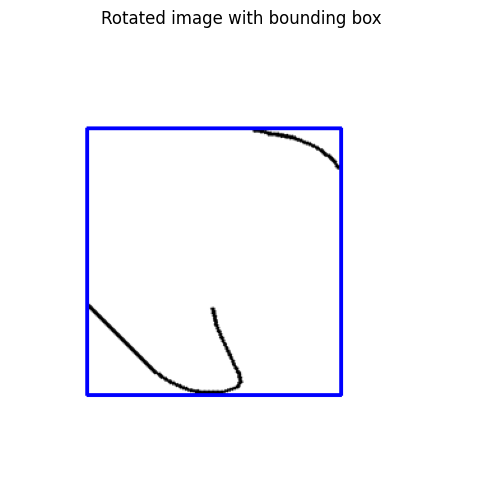

領域1の黒画素率: 0.0114
領域2の黒画素率: 0.0135
領域3の黒画素率: 0.0261
領域4の黒画素率: 0.0004

4領域の黒画素率: [np.float64(0.01141357421875), np.float64(0.01348876953125), np.float64(0.02606201171875), np.float64(0.00042724609375)]
エントロピー: 1.5428


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40658 (\N{CJK UNIFIED IDEOGRAPH-9ED2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

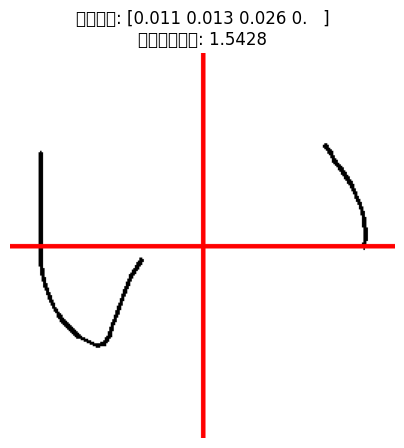

上の黒画素率: 0.0125
下の黒画素率: 0.0132
黒画素率の比（上:下）= 0.9401


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


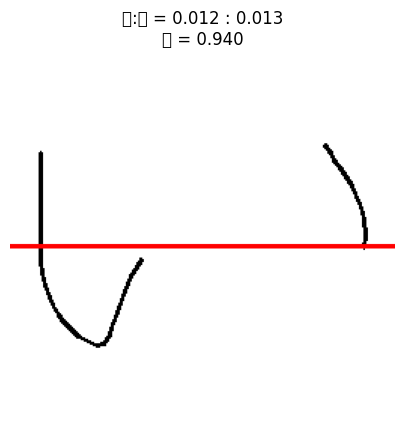

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24038 (\N{CJK UNIFIED IDEOGRAPH-5DE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21491 (\N{CJK UNIFIED IDEOGRAPH-53F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


左の黒画素率: 0.0187
右の黒画素率: 0.0070
黒画素率の比（左:右）= 2.6930


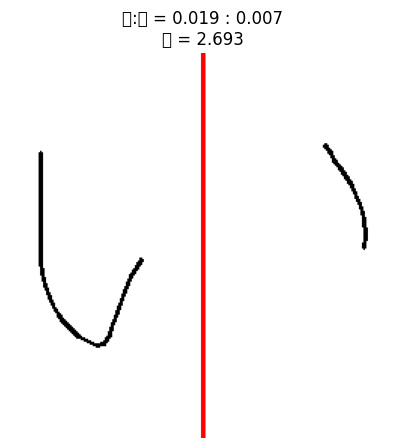

第1象限: 0.0135
第2象限: 0.0114
第3象限: 0.0261
第4象限: 0.0004
対角黒画素率比 (1+3) / (2+4) = 3.3402


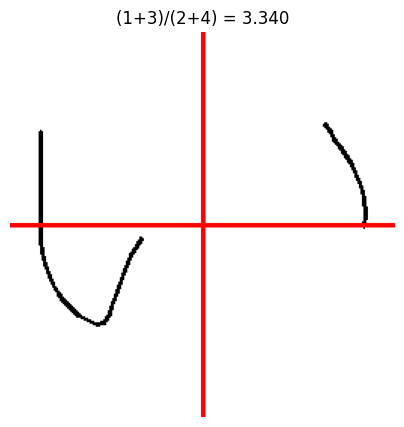

第1象限の距離: 104.38
第2象限の距離: 112.55
第3象限の距離: 86.10
第4象限の距離: 107.00

距離のエントroピー: 1.9930


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


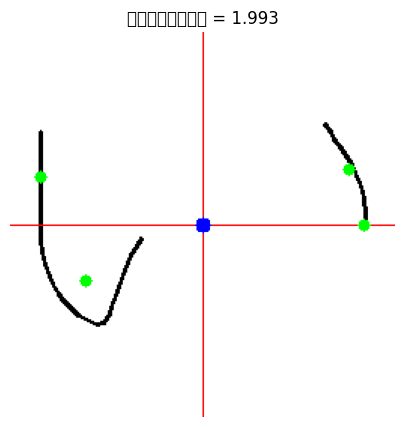

各象限の角度（ラジアン）:
第1象限: 0.358 rad
第2象限: 2.856 rad
第3象限: -2.692 rad
第4象限: -0.007 rad

平均角度: 1.189 rad
円周標準偏差: 2.4375


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

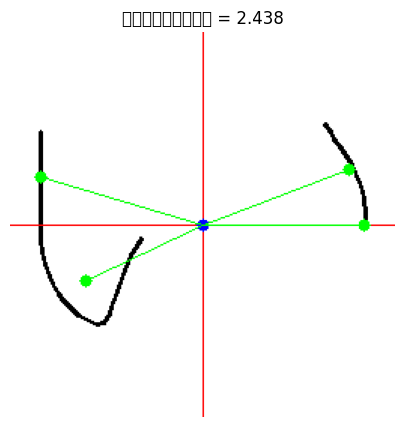

上側重心のx座標: 128.56
下側重心のx座標: 122.28
x方向の差（上 - 下）: 6.28


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


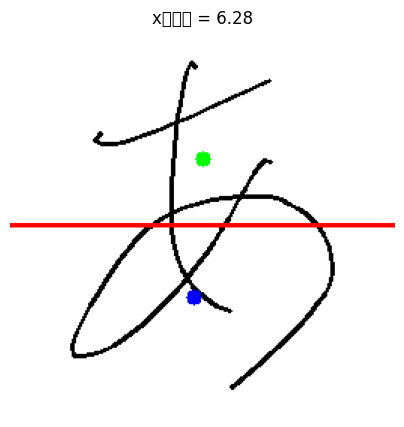

左側重心のy座標: 130.83
右側重心のy座標: 139.91
y方向の差（左 - 右）: -9.07


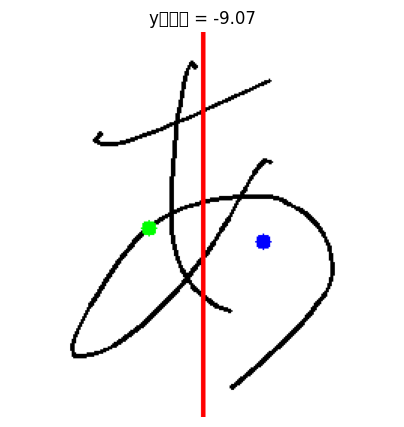

各部分系の黒画素数（背景除く）:
部分系 {k}: {area} pixels
部分系の数: 2
部分系が2つ → 面積比 = 2.693


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


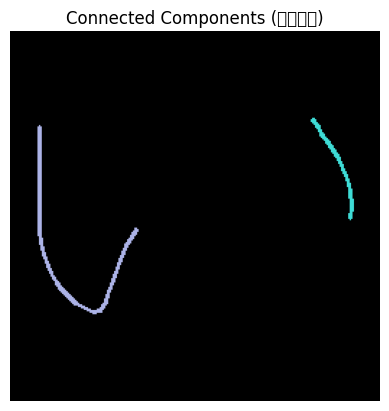

各部分系の外接矩形の面積（背景除く）:
部分系 1: 外接矩形面積 = 2130
部分系 2: 外接矩形面積 = 9170
部分系の数: 2
部分系が2つ → 外接矩形面積比 = 4.305


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


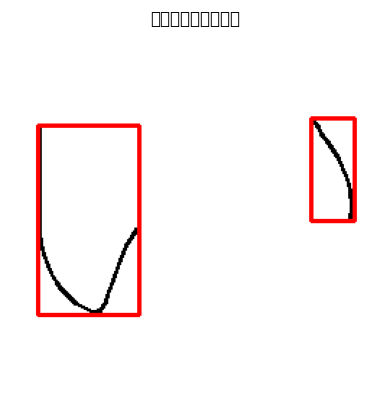

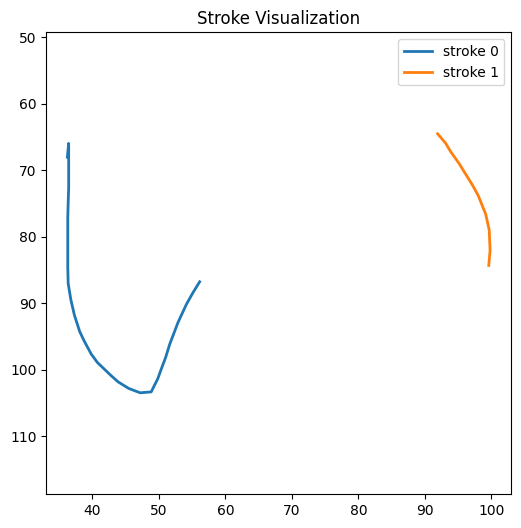

ストローク数: 2
各ストロークの画素数: [614, 228]
ストロークが2本 → 画素数比（時間順）= 2.693
ストローク数: 2
各ストロークの外接矩形面積（筆順）: [8614.75, 1805.72]
ストロークが2本 → 外接矩形面積比（筆順）= 4.771


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

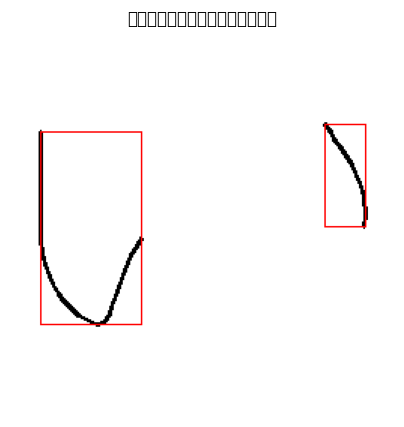

⚠️ A1-3.txt が見つかりません。スキップします。
⚠️ A1-4.txt が見つかりません。スキップします。
⚠️ A1-5.txt が見つかりません。スキップします。
⚠️ A1-6.txt が見つかりません。スキップします。
⚠️ A1-7.txt が見つかりません。スキップします。
⚠️ A1-8.txt が見つかりません。スキップします。
⚠️ A1-9.txt が見つかりません。スキップします。
⚠️ A1-10.txt が見つかりません。スキップします。
⚠️ A1-11.txt が見つかりません。スキップします。
⚠️ A1-12.txt が見つかりません。スキップします。
⚠️ A1-13.txt が見つかりません。スキップします。
⚠️ A1-14.txt が見つかりません。スキップします。
⚠️ A1-15.txt が見つかりません。スキップします。
⚠️ A1-16.txt が見つかりません。スキップします。
⚠️ A1-17.txt が見つかりません。スキップします。
⚠️ A1-18.txt が見つかりません。スキップします。
⚠️ A1-19.txt が見つかりません。スキップします。
⚠️ A1-20.txt が見つかりません。スキップします。
⚠️ A1-21.txt が見つかりません。スキップします。
⚠️ A1-22.txt が見つかりません。スキップします。
⚠️ A1-23.txt が見つかりません。スキップします。
⚠️ A1-24.txt が見つかりません。スキップします。
⚠️ A1-25.txt が見つかりません。スキップします。
⚠️ A1-26.txt が見つかりません。スキップします。
⚠️ A1-27.txt が見つかりません。スキップします。
⚠️ A1-28.txt が見つかりません。スキップします。
⚠️ A1-29.txt が見つかりません。スキップします。
⚠️ A1-30.txt が見つかりません。スキップします。
⚠️ A1-31.txt が見つかりません。スキップします。
⚠️ A1-32.txt が見つかりません。スキップします。
⚠️ A1-33.txt が見つかりません。スキップします。
⚠️ A1-34.txt が見つかりません。スキップします。
⚠️ A1-35.txt が見

In [12]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

for i in range(1, 50):
    txt_file = f"A1-{i}.txt"
    png_file = f"png/strokes {i}.png"

    if not os.path.exists(txt_file):
        print(f"⚠️ {txt_file} が見つかりません。スキップします。")
        continue

    #-------------

    # TXT読み込み
    df = pd.read_csv(txt_file, sep=',')
    df[['x','y','stroke_id']] = df[['x','y','stroke_id']].astype(float)

    # 元のバウンディングボックス
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()
    w, h = x_max - x_min, y_max - y_min

    # 出力サイズ
    out_size = 256
    margin = 20  # 周囲に余白（任意で調整）

    # スケーリング係数（長辺を out_size - 2*margin に収める）
    scale = (out_size - 2*margin) / max(w, h)

    # 出力キャンバス
    img = np.ones((out_size, out_size, 3), dtype=np.uint8) * 255

    # ストロークごとに描画
    for sid in df['stroke_id'].unique():
        stroke = df[df['stroke_id'] == sid].reset_index(drop=True)
        for j in range(1, len(stroke)): # Changed 'i' to 'j' to avoid conflict with loop variable 'i'
            x0 = int((stroke.loc[j-1, 'x'] - x_min) * scale + margin + (out_size - 2*margin - w*scale)/2)
            y0 = int((stroke.loc[j-1, 'y'] - y_min) * scale + margin + (out_size - 2*margin - h*scale)/2)
            x1 = int((stroke.loc[j, 'x'] - x_min) * scale + margin + (out_size - 2*margin - w*scale)/2)
            y1 = int((stroke.loc[j, 'y'] - y_min) * scale + margin + (out_size - 2*margin - h*scale)/2)
            cv.line(img, (x0, y0), (x1, y1), (0,0,0), 2)

    # 保存
    cv.imwrite(f"A1-{i}.png", img)

    #---------------

    #外接矩形の縦横比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 黒い部分を前景（白）にするため反転 ---
    bin_img = cv.bitwise_not(img)

    # --- 完全な二値化（念のため） ---
    _, bin_img = cv.threshold(bin_img, 128, 255, cv.THRESH_BINARY)

    # --- 輪郭抽出（黒画素を対象に） ---
    contours, _ = cv.findContours(bin_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # --- 外接矩形の統合 ---
    if len(contours) == 0:
        print("黒画素が見つかりません。")
    else:
        x_min = min([cv.boundingRect(c)[0] for c in contours])
        y_min = min([cv.boundingRect(c)[1] for c in contours])
        x_max = max([cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours])
        y_max = max([cv.boundingRect(c)[1] + cv.boundingRect(c)[3] for c in contours])

        w, h = x_max - x_min, y_max - y_min
        aspect_ratio = h / w if w > 0 else 0

        print(f"外接矩形: x={x_min}, y={y_min}, w={w}, h={h}")
        print(f"縦横比（h/w）: {aspect_ratio:.3f}")

    #-----------------

    #外接矩形の縦横比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 黒い部分を前景（白）にするため反転 ---
    bin_img = cv.bitwise_not(img)

    # --- 二値化（128を閾値に白黒化） ---
    _, bin_img = cv.threshold(bin_img, 128, 255, cv.THRESH_BINARY)

    # --- 輪郭抽出（黒画素を対象に） ---
    contours, _ = cv.findContours(bin_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # --- 結果の確認 ---
    if len(contours) == 0:
        print("⚠️ 黒画素が見つかりません。")
    else:
        # 外接矩形を統合
        x_min = min([cv.boundingRect(c)[0] for c in contours])
        y_min = min([cv.boundingRect(c)[1] for c in contours])
        x_max = max([cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours])
        y_max = max([cv.boundingRect(c)[1] + cv.boundingRect(c)[3] for c in contours])

        # 幅・高さ・縦横比
        w, h = x_max - x_min, y_max - y_min
        aspect_ratio = h / w if w > 0 else 0

        print(f"外接矩形: x={x_min}, y={y_min}, w={w}, h={h}")
        print(f"縦横比（h/w）: {aspect_ratio:.3f}")

        # --- 外接矩形を描画 ---
        color_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        cv.rectangle(color_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

        # --- Colab上で表示 ---
        plt.figure(figsize=(4,4))
        plt.imshow(cv.cvtColor(color_img, cv.COLOR_BGR2RGB))
        plt.title(f"Aspect ratio: {aspect_ratio:.3f}")
        plt.axis("off")
        plt.show()

    #-------------------

    #45°外接矩形の縦横比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 画像サイズと中心 ---
    h, w = img.shape
    center = (w // 2, h // 2)

    # --- 反時計回りに45°回転 ---
    angle = 45
    rot_mat = cv.getRotationMatrix2D(center, angle, 1.0)

    # 出力画像サイズ（回転しても切れないように拡張）
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # 回転中心を補正
    rot_mat[0, 2] += (new_w / 2) - center[0]
    rot_mat[1, 2] += (new_h / 2) - center[1]

    # --- 回転実行 ---
    rotated = cv.warpAffine(img, rot_mat, (new_w, new_h), flags=cv.INTER_LINEAR, borderValue=255)

    # --- 二値化（黒→白に反転） ---
    _, bin_img = cv.threshold(rotated, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 輪郭抽出（黒画素領域） ---
    contours, _ = cv.findContours(bin_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # --- 全ての輪郭の外接矩形を統合 ---
    x_min = min([cv.boundingRect(c)[0] for c in contours])
    y_min = min([cv.boundingRect(c)[1] for c in contours])
    x_max = max([cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours])
    y_max = max([cv.boundingRect(c)[1] + cv.boundingRect(c)[3] for c in contours])

    # --- 外接矩形の幅・高さ・縦横比 ---
    W, H = x_max - x_min, y_max - y_min
    aspect_ratio = H / W

    print(f"外接矩形: x={x_min}, y={y_min}, w={W}, h={H}")
    print(f"外接矩形の縦横比: {aspect_ratio:.3f}")

    # --- 確認用に矩形を描画 ---
    rect_img = cv.cvtColor(rotated, cv.COLOR_GRAY2BGR)
    cv.rectangle(rect_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

    # --- 結果表示 ---
    plt.figure(figsize=(6,6))
    plt.imshow(rect_img)
    plt.axis('off')
    plt.title("Rotated image with bounding box")
    plt.show()

    #------------

    #4分割黒画素比エントロピー
    from math import log2

    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 画像サイズ取得 ---
    h, w = bin_img.shape

    # --- 4分割（上左・上右・下左・下右） ---
    h_half, w_half = h // 2, w // 2
    regions = [
        bin_img[0:h_half, 0:w_half],      # 左上
        bin_img[0:h_half, w_half:w],      # 右上
        bin_img[h_half:h, 0:w_half],      # 左下
        bin_img[h_half:h, w_half:w],      # 右下
    ]

    # --- 各領域の黒画素率を計算 ---
    black_ratios = []
    for k, region in enumerate(regions): # Changed 'i' to 'k' to avoid conflict with loop variable 'i'
        black_pixels = np.sum(region > 0)      # 黒画素（255値）の数
        total_pixels = region.size
        ratio = black_pixels / total_pixels
        black_ratios.append(ratio)
        print(f"領域{k+1}の黒画素率: {ratio:.4f}")

    # --- エントロピーを計算 ---
    # ※ 0 を含むと log2(0) になるので、微小値を加える
    p = np.array(black_ratios)
    p = p / p.sum() if p.sum() > 0 else p  # 確率として正規化
    entropy = -np.sum([x * log2(x) for x in p if x > 0])

    print(f"\n4領域の黒画素率: {black_ratios}")
    print(f"エントロピー: {entropy:.4f}")

    #-----------

    # --- 分割線を描画 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)  # 垂直線
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)  # 水平線

    # --- 表示 ---
    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"黒画素率: {np.round(black_ratios, 3)}\nエントロピー: {entropy:.4f}")
    plt.axis("off")
    plt.show()

    #-------------

    #上下黒画素率比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 画像サイズ取得 ---
    h, w = bin_img.shape
    h_half = h // 2

    # --- 上下2分割 ---
    top = bin_img[0:h_half, :]
    bottom = bin_img[h_half:h, :]

    # --- 各領域の黒画素率を計算 ---
    def black_ratio(region):
        return np.sum(region > 0) / region.size

    top_ratio = black_ratio(top)
    bottom_ratio = black_ratio(bottom)

    # --- 黒画素率の比（上:下）を計算 ---
    # 下が0の場合のエラー防止
    ratio = top_ratio / bottom_ratio if bottom_ratio > 0 else np.inf

    # --- 結果出力 ---
    print(f"上の黒画素率: {top_ratio:.4f}")
    print(f"下の黒画素率: {bottom_ratio:.4f}")
    print(f"黒画素率の比（上:下）= {ratio:.4f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"上:下 = {top_ratio:.3f} : {bottom_ratio:.3f}\n比 = {ratio:.3f}")
    plt.axis("off")
    plt.show()

    #------------

    #左右黒画素率比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 画像サイズ取得 ---
    h, w = bin_img.shape
    w_half = w // 2

    # --- 左右2分割 ---
    left = bin_img[:, 0:w_half]
    right = bin_img[:, w_half:w]

    # --- 各領域の黒画素率を計算 ---
    def black_ratio(region):
        return np.sum(region > 0) / region.size

    left_ratio = black_ratio(left)
    right_ratio = black_ratio(right)

    # --- 黒画素率の比（左:右）を計算 ---
    ratio = left_ratio / right_ratio if right_ratio > 0 else np.inf

    # --- 結果出力 ---
    print(f"左の黒画素率: {left_ratio:.4f}")
    print(f"右の黒画素率: {right_ratio:.4f}")
    print(f"黒画素率の比（左:右）= {ratio:.4f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"左:右 = {left_ratio:.3f} : {right_ratio:.3f}\n比 = {ratio:.3f}")
    plt.axis("off")
    plt.show()

    #------------

    #対角黒画素率比
    # --- 画像読み込み（グレースケール） ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- サイズ取得 ---
    h, w = bin_img.shape
    h_half, w_half = h // 2, w // 2

    # --- 4分割 ---
    q1 = bin_img[0:h_half, w_half:w]     # 第1象限（右上）
    q2 = bin_img[0:h_half, 0:w_half]     # 第2象限（左上）
    q3 = bin_img[h_half:h, 0:w_half]     # 第3象限（左下）
    q4 = bin_img[h_half:h, w_half:w]     # 第4象限（右下）

    # --- 黒画素率計算 ---
    def black_ratio(region):
        return np.sum(region > 0) / region.size

    r1, r2, r3, r4 = map(black_ratio, [q1, q2, q3, q4])

    # --- 対角比 (第1+第3) / (第2+第4) ---
    num = r1 + r3
    den = r2 + r4
    diag_ratio = num / den if den > 0 else np.inf

    # --- 結果出力 ---
    print(f"第1象限: {r1:.4f}")
    print(f"第2象限: {r2:.4f}")
    print(f"第3象限: {r3:.4f}")
    print(f"第4象限: {r4:.4f}")
    print(f"対角黒画素率比 (1+3) / (2+4) = {diag_ratio:.4f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"(1+3)/(2+4) = {diag_ratio:.3f}")
    plt.axis("off")
    plt.show()

    #------------

    #4分割重心距離エントロピー
    # --- 画像読み込み ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- サイズと中心 ---
    h, w = bin_img.shape
    h_half, w_half = h // 2, w // 2
    center = np.array([w / 2, h / 2])

    # --- 4分割（完全4等分版） ---
    q1 = bin_img[0:h_half, w_half:w]      # 第1象限（右上）
    q2 = bin_img[0:h_half, 0:w_half]      # 第2象限（左上）
    q3 = bin_img[h_half:h, 0:w_half]      # 第3象限（左下）
    q4 = bin_img[h_half:h, w_half:w]      # 第4象限（右下）
    quadrants = [q1, q2, q3, q4]

    # --- 各領域のオフセット（座標原点を画像全体座標系に合わせる） ---
    offsets = [
        (w_half, 0),     # q1
        (0, 0),          # q2
        (0, h_half),     # q3
        (w_half, h_half) # q4
    ]

    # --- 各領域の重心を求める ---
    centroids = []
    for q, (ox, oy) in zip(quadrants, offsets):
        ys, xs = np.where(q > 0)
        if len(xs) == 0:
            centroids.append(None)
            continue
        cx = np.mean(xs) + ox
        cy = np.mean(ys) + oy
        centroids.append(np.array([cx, cy]))

    # --- 画像中心からの距離を計算 ---
    distances = []
    for c in centroids:
        if c is not None:
            d = np.linalg.norm(c - center)
            distances.append(d)
        else:
            distances.append(0.0)  # 黒画素がない場合は0距離に

    # --- 正規化してエントロピーを算出 ---
    p = np.array(distances) / np.sum(distances)
    entropy = -np.sum(p * np.log2(p + 1e-10))  # 0対策

    # --- 結果表示 ---
    for k, d in enumerate(distances, start=1): # Changed 'i' to 'k'
        print(f"第{k}象限の距離: {d:.2f}")
    print(f"\n距離のエントroピー: {entropy:.4f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 1)
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 1)

    # 重心点描画
    for c in centroids:
        if c is not None:
            cv.circle(vis, (int(c[0]), int(c[1])), 4, (0, 255, 0), -1)

    # 中心点描画
    cv.circle(vis, (int(center[0]), int(center[1])), 5, (255, 0, 0), -1)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"距離エントロピー = {entropy:.3f}")
    plt.axis("off")
    plt.show()

    #----------

    #4分割重心角度標準偏差
    # --- 画像読み込み ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- サイズと中心 ---
    h, w = bin_img.shape
    h_half, w_half = h // 2, w // 2
    center = np.array([w / 2, h / 2])

    # --- 4分割 ---
    q1 = bin_img[0:h_half, w_half:w]      # 第1象限（右上）
    q2 = bin_img[0:h_half, 0:w_half]      # 第2象限（左上）
    q3 = bin_img[h_half:h, 0:w_half]      # 第3象限（左下）
    q4 = bin_img[h_half:h, w_half:w]      # 第4象限（右下）
    quadrants = [q1, q2, q3, q4]

    # --- 各領域のオフセット ---
    offsets = [
        (w_half, 0),     # q1
        (0, 0),          # q2
        (0, h_half),     # q3
        (w_half, h_half) # q4
    ]

    # --- 各領域の重心 ---
    centroids = []
    for q, (ox, oy) in zip(quadrants, offsets):
        ys, xs = np.where(q > 0)
        if len(xs) == 0:
            centroids.append(None)
            continue
        cx = np.mean(xs) + ox
        cy = np.mean(ys) + oy
        centroids.append(np.array([cx, cy]))

    # --- 中心→重心ベクトルの角度を求める ---
    angles = []
    for c in centroids:
        if c is not None:
            dx, dy = c - center
            angle = np.arctan2(-dy, dx)  # y軸下向き補正（画像座標系→通常座標系）
            angles.append(angle)
    angles = np.array(angles)

    # --- 円周統計: 標準偏差 ---
    mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
    R = np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2)
    circ_std = np.sqrt(-2 * np.log(R))

    # --- 結果 ---
    print("各象限の角度（ラジアン）:")
    for k, a in enumerate(angles, start=1): # Changed 'i' to 'k'
        print(f"第{k}象限: {a:.3f} rad")
    print(f"\n平均角度: {mean_angle:.3f} rad")
    print(f"円周標準偏差: {circ_std:.4f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 1)
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 1)
    cv.circle(vis, (int(center[0]), int(center[1])), 4, (255, 0, 0), -1)

    # 各重心を描画 + ベクトル線
    for c in centroids:
        if c is not None:
            cv.circle(vis, (int(c[0]), int(c[1])), 4, (0, 255, 0), -1)
            cv.line(vis, (int(center[0]), int(center[1])), (int(c[0]), int(c[1])), (0, 255, 0), 1)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"角度の円周標準偏差 = {circ_std:.3f}")
    plt.axis("off")
    plt.show()

    #----------

    #上下重心距離差
    # --- 画像読み込み ---
    img = cv.imread("A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- サイズ取得 ---
    h, w = bin_img.shape
    h_half = h // 2

    # --- 上下2分割 ---
    top = bin_img[0:h_half, :]
    bottom = bin_img[h_half:h, :]

    # --- 黒画素の重心を求める関数 ---
    def centroid(region, offset_y=0):
        ys, xs = np.where(region > 0)
        if len(xs) == 0:
            return None
        cx = np.mean(xs)
        cy = np.mean(ys) + offset_y
        return np.array([cx, cy])

    # --- 各領域の重心 ---
    top_c = centroid(top, 0)
    bottom_c = centroid(bottom, h_half)

    # --- x座標の差 ---
    if top_c is not None and bottom_c is not None:
        dx = top_c[0] - bottom_c[0]
    else:
        dx = np.nan

    print(f"上側重心のx座標: {top_c[0]:.2f}")
    print(f"下側重心のx座標: {bottom_c[0]:.2f}")
    print(f"x方向の差（上 - 下）: {dx:.2f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)  # 分割線

    # 重心を描画
    for c, color in zip([top_c, bottom_c], [(0,255,0), (255,0,0)]):
        if c is not None:
            cv.circle(vis, (int(c[0]), int(c[1])), 5, color, -1)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"x方向差 = {dx:.2f}")
    plt.axis("off")
    plt.show()

    #---------------

    #左右重心距離差
    # --- 画像読み込み ---
    img = cv.imread("A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字→白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- サイズ取得 ---
    h, w = bin_img.shape
    w_half = w // 2

    # --- 左右2分割 ---
    left = bin_img[:, 0:w_half]
    right = bin_img[:, w_half:w]

    # --- 黒画素の重心を求める関数 ---
    def centroid(region, offset_x=0):
        ys, xs = np.where(region > 0)
        if len(xs) == 0:
            return None
        cx = np.mean(xs) + offset_x
        cy = np.mean(ys)
        return np.array([cx, cy])

    # --- 各領域の重心 ---
    left_c = centroid(left, 0)
    right_c = centroid(right, w_half)

    # --- y座標の差 ---
    if left_c is not None and right_c is not None:
        dy = left_c[1] - right_c[1]
    else:
        dy = np.nan

    print(f"左側重心のy座標: {left_c[1]:.2f}")
    print(f"右側重心のy座標: {right_c[1]:.2f}")
    print(f"y方向の差（左 - 右）: {dy:.2f}")

    # --- 可視化 ---
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)  # 分割線

    # 重心を描画
    for c, color in zip([left_c, right_c], [(0,255,0), (255,0,0)]):
        if c is not None:
            cv.circle(vis, (int(c[0]), int(c[1])), 5, color, -1)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(f"y方向差 = {dy:.2f}")
    plt.axis("off")
    plt.show()

    #-------------

    #部分系長さ
    # --- 画像読み込み ---
    img = cv.imread("A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 連結成分解析 ---
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

    # --- 背景(ラベル0)を除く ---
    areas = stats[1:, cv.CC_STAT_AREA]  # 1番目以降が文字部分


    print("各部分系の黒画素数（背景除く）:")
    for k, area in enumerate(areas, start=1): # Changed 'i' to 'k'
        print("部分系 {k}: {area} pixels")

    #--------------

    #部分系長さの比やエントロピー
    # --- 画像読み込み ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 連結成分解析 ---
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

    # --- 背景を除いた部分系の黒画素数 ---
    areas = stats[1:, cv.CC_STAT_AREA]  # 背景を除く
    n = len(areas)

    print(f"部分系の数: {n}")

    # --- 場合分け ---
    if n == 0:
        print("黒画素の連結成分が存在しません。")

    elif n == 1:
        print("部分系が1つのため、比・エントロピーはなし。")

    elif n == 2:
        ratio = max(areas) / min(areas)
        print(f"部分系が2つ → 面積比 = {ratio:.3f}")

    else:
        # --- エントロピーを手計算で求める ---
        p = areas / np.sum(areas)  # 各部分系の黒画素割合
        entropy = -np.sum(p * np.log2(p + 1e-12))  # log(0)防止のため微小値を加算
        print(f"部分系が{n}個 → 黒画素分布のエントロピー = {entropy:.3f} bits")

    #------------

    #部分系の表示
    colored = np.zeros((*bin_img.shape, 3), dtype=np.uint8)
    for k in range(1, num_labels): # Changed 'i' to 'k'
        color = np.random.randint(0, 255, size=3).tolist()
        colored[labels == k] = color

    plt.imshow(colored)
    plt.title("Connected Components (各部分系)")
    plt.axis("off")
    plt.show()

    #-------------

    #部分系外接矩形面積
    # --- 画像読み込み ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 連結成分解析 ---
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

    print("各部分系の外接矩形の面積（背景除く）:")
    for k in range(1, num_labels):  # 0は背景 # Changed 'i' to 'k'
        x, y, w, h, area = stats[k]
        bbox_area = w * h
        print(f"部分系 {k}: 外接矩形面積 = {bbox_area}")

    #---------------

    #部分系面積の比やエントロピー
    # --- 画像読み込み ---
    img = cv.imread(f"A1-{i}.png", cv.IMREAD_GRAYSCALE)

    # --- 二値化（黒文字を白に反転）---
    _, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # --- 連結成分解析 ---
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

    # --- 背景を除いた外接矩形の面積 ---
    widths  = stats[1:, cv.CC_STAT_WIDTH]
    heights = stats[1:, cv.CC_STAT_HEIGHT]
    bbox_areas = widths * heights
    n = len(bbox_areas)

    print(f"部分系の数: {n}")

    # --- 場合分け ---
    if n == 0:
        print("黒画素の連結成分が存在しません。")

    elif n == 1:
        print("部分系が1つのため、比・エントロピーはなし。")

    elif n == 2:
        ratio = max(bbox_areas) / min(bbox_areas)
        print(f"部分系が2つ → 外接矩形面積比 = {ratio:.3f}")

    else:
        p = np.array(bbox_areas) / np.sum(bbox_areas)
        entropy = -np.sum(p * np.log2(p + 1e-12))
        print(f"部分系が{n}個 → 外接矩形面積分布のエントロピー = {entropy:.3f} bits")

    #--------------

    #部分系外接矩形面積の表示
    colored = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    for k in range(1, num_labels): # Changed 'i' to 'k'
        x, y, w, h, area = stats[k]
        cv.rectangle(colored, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.imshow(cv.cvtColor(colored, cv.COLOR_BGR2RGB))
    plt.title("各部分系の外接矩形")
    plt.axis("off")
    plt.show()

    #--------------

    #ストロークの抽出
    # --- データ読み込み ---
    df = pd.read_csv(f"A1-{i}.txt")

    # --- stroke_idごとにグループ化 ---
    groups = df.groupby("stroke_id")

    # --- 描画 ---
    plt.figure(figsize=(6, 6))
    for stroke_id, g in groups:
        plt.plot(g["x"], g["y"], linewidth=2, label=f"stroke {stroke_id}")

    plt.gca().invert_yaxis()  # 画像と同じ座標系にする（y軸反転）
    plt.axis("equal")
    plt.legend()
    plt.title("Stroke Visualization")
    plt.show()

    #-------------

    #ストローク長さの比やエントロピー（時間順）

    # --- データ読み込み ---
    df = pd.read_csv(f"A1-{i}.txt")

    # --- stroke_idごとに画素数を算出 ---
    stroke_pixels = []
    out_size = 256
    margin = 20
    x_min, x_max = df["x"].min(), df["x"].max()
    y_min, y_max = df["y"].min(), df["y"].max()
    w, h = x_max - x_min, y_max - y_min
    scale = (out_size - 2*margin) / max(w, h)
    offset_x = margin + (out_size - 2*margin - w*scale)/2
    offset_y = margin + (out_size - 2*margin - h*scale)/2

    for sid in sorted(df["stroke_id"].unique()):
        stroke = df[df["stroke_id"] == sid].reset_index(drop=True)
        img = np.zeros((out_size, out_size), dtype=np.uint8)
        for k in range(1, len(stroke)): # Changed 'i' to 'k'
            x0 = int((stroke.loc[k-1, "x"] - x_min) * scale + offset_x)
            y0 = int((stroke.loc[k-1, "y"] - y_min) * scale + offset_y)
            x1 = int((stroke.loc[k, "x"] - x_min) * scale + offset_x)
            y1 = int((stroke.loc[k, "y"] - y_min) * scale + offset_y)
            cv.line(img, (x0, y0), (x1, y1), 255, 2)
        stroke_pixels.append(np.count_nonzero(img))

    # --- 場合分け ---
    n = len(stroke_pixels)
    print(f"ストローク数: {n}")
    print("各ストロークの画素数:", stroke_pixels)

    if n == 0:
        print("ストロークが存在しません。")

    elif n == 1:
        print("ストロークが1本のため、比・エントロピーはなし。")

    elif n == 2:
        ratio = stroke_pixels[0] / stroke_pixels[1]
        print(f"ストロークが2本 → 画素数比（時間順）= {ratio:.3f}")

    else:
        p = np.array(stroke_pixels) / np.sum(stroke_pixels)
        entropy = -np.sum(p * np.log2(p + 1e-12))
        print(f"ストロークが{n}本 → エントロピー = {entropy:.3f} bits")

    #-------------

    #ストローク面積の比やエントロピー（時間順）
    # --- ① TXT読み込み ---
    txt_file = f"A1-{i}.txt"
    df = pd.read_csv(txt_file, sep=',')
    df[['x','y','stroke_id']] = df[['x','y','stroke_id']].astype(float)

    # --- ② スケーリング・位置補正 ---
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()
    w, h = x_max - x_min, y_max - y_min

    out_size = 256
    margin = 20
    scale = (out_size - 2*margin) / max(w, h)
    offset_x = margin + (out_size - 2*margin - w*scale)/2
    offset_y = margin + (out_size - 2*margin - h*scale)/2

    # --- ③ 各ストロークの外接矩形面積を計算 ---
    bbox_areas = []
    stroke_ids = sorted(df['stroke_id'].unique())  # 時間順（筆順）

    for sid in stroke_ids:
        stroke = df[df['stroke_id'] == sid].reset_index(drop=True)

        xs = (stroke['x'] - x_min) * scale + offset_x
        ys = (stroke['y'] - y_min) * scale + offset_y

        x_min_s, x_max_s = xs.min(), xs.max()
        y_min_s, y_max_s = ys.min(), ys.max()

        w_s = x_max_s - x_min_s
        h_s = y_max_s - y_min_s
        area = w_s * h_s
        bbox_areas.append(area)

    # --- ④ 結果の出力 ---
    n = len(bbox_areas)
    print(f"ストローク数: {n}")
    print("各ストロークの外接矩形面積（筆順）:", [round(a, 2) for a in bbox_areas])

    if n == 0:
        print("ストロークが存在しません。")

    elif n == 1:
        print("ストロークが1本のため、比・エントロピーはなし。")

    elif n == 2:
        ratio = bbox_areas[0] / bbox_areas[1]
        print(f"ストロークが2本 → 外接矩形面積比（筆順）= {ratio:.3f}")

    else:
        p = np.array(bbox_areas) / np.sum(bbox_areas)
        entropy = -np.sum(p * np.log2(p + 1e-12))
        print(f"ストロークが{n}本 → 外接矩形面積分布のエントロピー = {entropy:.3f} bits")

    # --- ⑤ 可視化　---
    img = np.ones((out_size, out_size, 3), dtype=np.uint8) * 255
    for sid in stroke_ids:
        stroke = df[df['stroke_id'] == sid].reset_index(drop=True)
        for k in range(1, len(stroke)): # Changed 'i' to 'k'
            x0 = int((stroke.loc[k-1, 'x'] - x_min) * scale + offset_x)
            y0 = int((stroke.loc[k-1, 'y'] - y_min) * scale + offset_y)
            x1 = int((stroke.loc[k, 'x'] - x_min) * scale + offset_x)
            y1 = int((stroke.loc[k, 'y'] - y_min) * scale + offset_y)
            cv.line(img, (x0, y0), (x1, y1), (0,0,0), 2)

    # 外接矩形を描画
    for sid, area in zip(stroke_ids, bbox_areas):
        stroke = df[df['stroke_id'] == sid]
        xs = (stroke['x'] - x_min) * scale + offset_x
        ys = (stroke['y'] - y_min) * scale + offset_y
        x_min_s, x_max_s = int(xs.min()), int(xs.max())
        y_min_s, y_max_s = int(ys.min()), int(ys.max())
        cv.rectangle(img, (x_min_s, y_min_s), (x_max_s, y_max_s), (0,0,255), 1)

    plt.figure(figsize=(5,5))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("各ストロークの外接矩形（筆順）")
    plt.axis("off")
    plt.show()